In [ ]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

## Loading dataset

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv')

In [ ]:
# Dataset exploration

data.shape

(31962, 3)

In [ ]:
data.head(5)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
# Checking for missing values

data.isnull().values.any()

False

<Axes: xlabel='label', ylabel='count'>

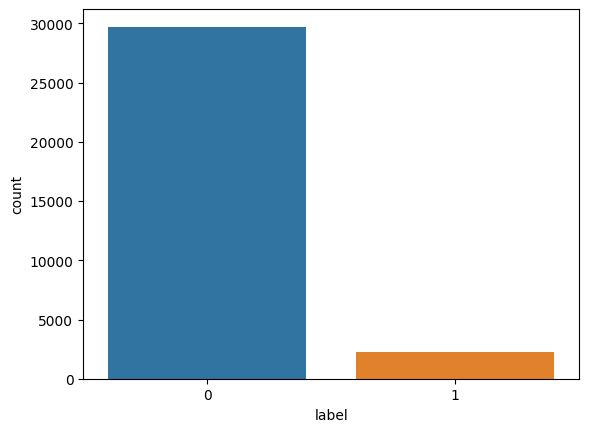

In [ ]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='label', data=data)

## Data Preprocessing

In [ ]:
data["tweet"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next section

'  bihday your majesty'

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
X = []
sentences = list(data['tweet'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
# Sample cleaned up movie review

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

' bihday majesty'

In [ ]:
# Converting sentiment labels to 0 & 1
# 0=negative 1=positive
y = data['label']

y = np.array(list(map(lambda x: 1 if x==1 else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

## Preparing embedding layer

In [ ]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

32653

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/sentiment analysis/a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(32653, 100)

# Model Training with:

## Simple Neural Network

In [ ]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          3265300   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 3275301 (12.49 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 3265300 (12.46 MB)
_________________________________________________________________
None


In [ ]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
320/320 [==============================] - 1s 3ms/step - loss: 0.2386 - acc: 0.9296 - val_loss: 0.1960 - val_acc: 0.9359
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 0.1800 - acc: 0.9416 - val_loss: 0.1842 - val_acc: 0.9378
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 0.1667 - acc: 0.9458 - val_loss: 0.1808 - val_acc: 0.9376
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 0.1583 - acc: 0.9481 - val_loss: 0.1777 - val_acc: 0.9386
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 0.1524 - acc: 0.9499 - val_loss: 0.1763 - val_acc: 0.9380
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 0.1478 - acc: 0.9512 - val_loss: 0.1766 - val_acc: 0.9376
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 0.1440 - acc: 0.9518 - val_loss: 0.1769 - val_acc: 0.9380
Epoch 8/10
320/320 [==============================] - 1s 2ms/step - loss: 0.

In [ ]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

200/200 [==============================] - 0s 1ms/step - loss: 0.1742 - acc: 0.9417


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.1741768717765808
Test Accuracy: 0.9416549205780029


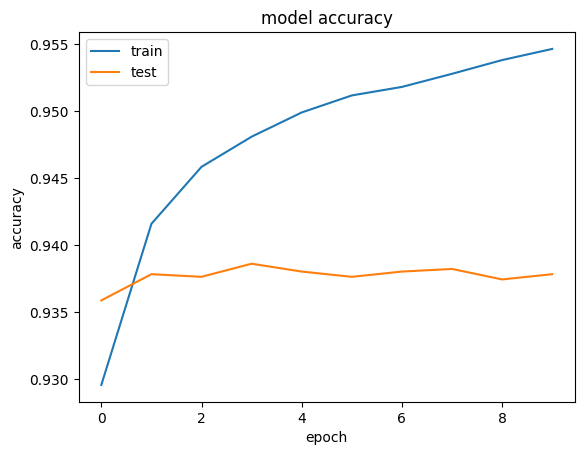

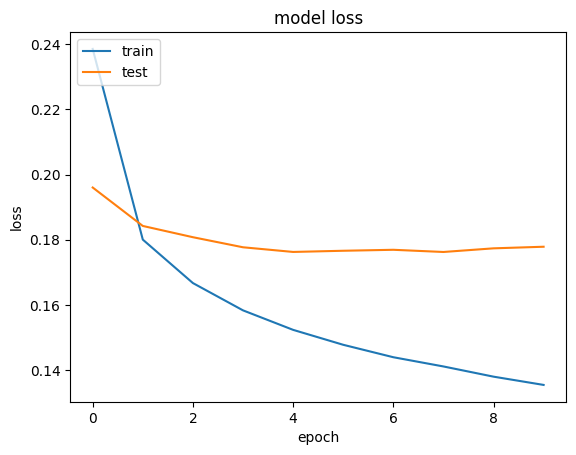

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [ ]:
from keras.layers import Conv1D

In [ ]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(64, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          3265300   
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 64)            32064     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3297429 (12.58 MB)
Trainable params: 32129 (125.50 KB)
Non-trainable params: 3265300 (12.46 MB)
_________________________________________________________________
None


In [ ]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
320/320 [==============================] - 7s 20ms/step - loss: 0.1710 - acc: 0.9429 - val_loss: 0.1544 - val_acc: 0.9441
Epoch 2/10
320/320 [==============================] - 5s 17ms/step - loss: 0.1227 - acc: 0.9565 - val_loss: 0.1432 - val_acc: 0.9482
Epoch 3/10
320/320 [==============================] - 6s 19ms/step - loss: 0.0950 - acc: 0.9675 - val_loss: 0.1412 - val_acc: 0.9499
Epoch 4/10
320/320 [==============================] - 5s 17ms/step - loss: 0.0719 - acc: 0.9764 - val_loss: 0.1398 - val_acc: 0.9496
Epoch 5/10
320/320 [==============================] - 6s 20ms/step - loss: 0.0538 - acc: 0.9843 - val_loss: 0.1440 - val_acc: 0.9521
Epoch 6/10
320/320 [==============================] - 5s 17ms/step - loss: 0.0397 - acc: 0.9897 - val_loss: 0.1490 - val_acc: 0.9505
Epoch 7/10
320/320 [==============================] - 6s 20ms/step - loss: 0.0279 - acc: 0.9937 - val_loss: 0.1497 - val_acc: 0.9517
Epoch 8/10
320/320 [==============================] - 6s 18ms/step - 

In [ ]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

200/200 [==============================] - 1s 4ms/step - loss: 0.1724 - acc: 0.9496


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.17236629128456116
Test Accuracy: 0.9496324062347412


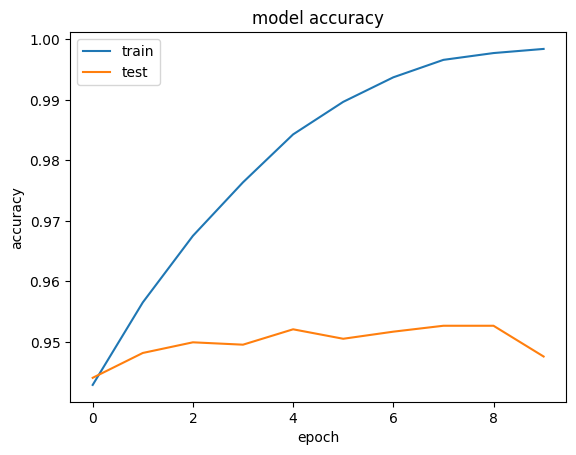

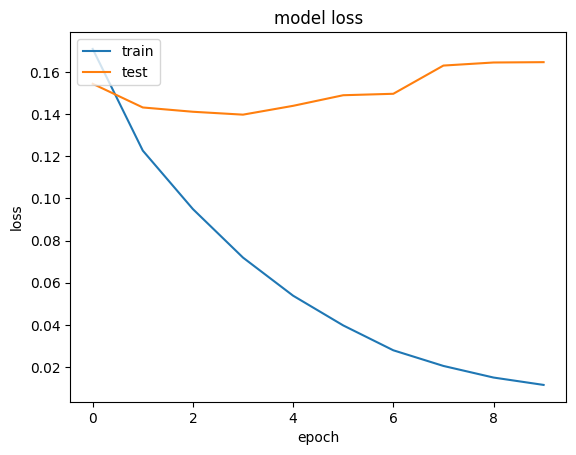

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [ ]:
from keras.layers import LSTM

In [ ]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(64))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 100)          3265300   
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3307605 (12.62 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 3265300 (12.46 MB)
_________________________________________________________________
None


In [ ]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
320/320 [==============================] - 22s 63ms/step - loss: 0.2723 - acc: 0.9290 - val_loss: 0.2580 - val_acc: 0.9284
Epoch 2/10
320/320 [==============================] - 22s 67ms/step - loss: 0.2528 - acc: 0.9306 - val_loss: 0.2580 - val_acc: 0.9284
Epoch 3/10
320/320 [==============================] - 20s 62ms/step - loss: 0.2526 - acc: 0.9306 - val_loss: 0.2579 - val_acc: 0.9284
Epoch 4/10
320/320 [==============================] - 20s 62ms/step - loss: 0.2526 - acc: 0.9306 - val_loss: 0.2578 - val_acc: 0.9284
Epoch 5/10
320/320 [==============================] - 19s 61ms/step - loss: 0.2525 - acc: 0.9306 - val_loss: 0.2582 - val_acc: 0.9284
Epoch 6/10
320/320 [==============================] - 19s 58ms/step - loss: 0.2524 - acc: 0.9306 - val_loss: 0.2593 - val_acc: 0.9284
Epoch 7/10
320/320 [==============================] - 20s 61ms/step - loss: 0.2525 - acc: 0.9306 - val_loss: 0.2590 - val_acc: 0.9284
Epoch 8/10
320/320 [==============================] - 19s 58ms

In [ ]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

200/200 [==============================] - 3s 14ms/step - loss: 0.2579 - acc: 0.9287


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.25785401463508606
Test Accuracy: 0.9286719560623169


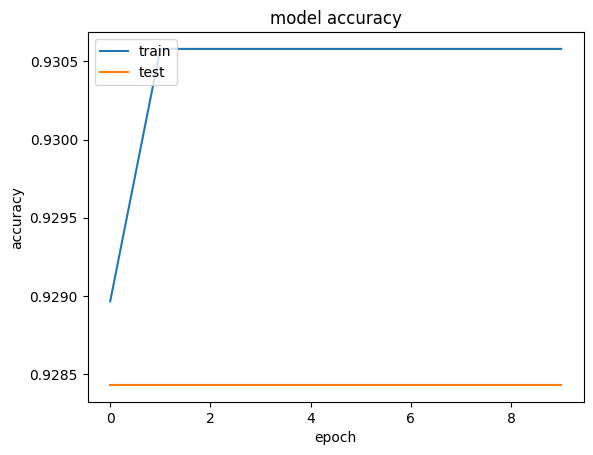

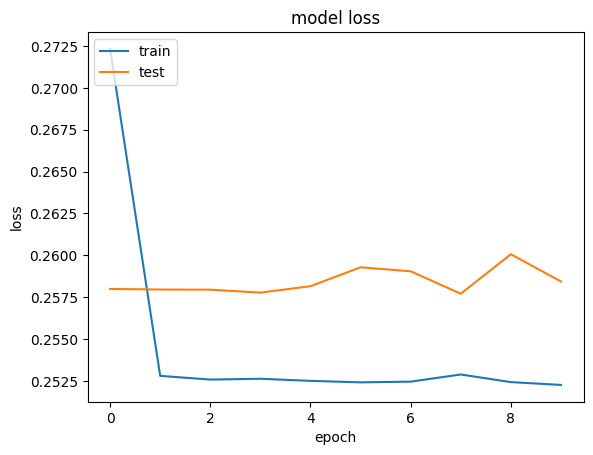

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"lstm{round(score[1], 3)}.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Making Predictions on Live IMDb data

In [ ]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("/content/drive/MyDrive/sentiment analysis/a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [ ]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [ ]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [ ]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

1/1 [==============================] - 0s 19ms/step


In [ ]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,5)

df_prediction_sentiments = pd.DataFrame([1 if i>0.655 else 0 for i in sample_reviews['Predicted Sentiments']], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,1
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,1
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,0
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,1
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,1
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,1
